# PaCMAP cluster plot

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from birdclef.utils import get_spark
from pyspark.sql import functions as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/03 08:13:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/07/03 08:13:53 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
# Path and dataset names
root = "gs://dsgt-clef-birdclef-2024/data"
metadata_path = "raw/birdclef-2024/train_metadata.csv"
google_emb_path = "processed/google_embeddings/v1"
encodec_emb_path = "processed/encodec_embeddings/v2"
birdnet_emb_path = "processed/birdnet/v1"
# unlabeled_path = "intermediate/google_soundscape_embeddings/v1"

# Read the Parquet file into a DataFrame
metadata_df = spark.read.csv(f"{root}/{metadata_path}", header=True)
google_df = spark.read.parquet(f"{root}/{google_emb_path}")
encodec_df = spark.read.parquet(f"{root}/{encodec_emb_path}")
birdnet_df = spark.read.parquet(f"{root}/{birdnet_emb_path}")

# show
metadata_df.show(n=3, truncate=50)
google_df.show(n=3, truncate=50)
encodec_df.show(n=3, truncate=50)
birdnet_df.show(n=3, truncate=50)
# unlabeled_df_df.show(n=3, truncate=50)

+-------------+----------------+--------+--------+---------+------------------+----------------------+----------------+--------------------------------------------------+------+---------------------------------+-------------------+
|primary_label|secondary_labels|    type|latitude|longitude|   scientific_name|           common_name|          author|                                           license|rating|                              url|           filename|
+-------------+----------------+--------+--------+---------+------------------+----------------------+----------------+--------------------------------------------------+------+---------------------------------+-------------------+
|       asbfly|              []|['call']| 39.2297| 118.1987|Muscicapa dauurica|Asian Brown Flycatcher|  Matt Slaymaker|Creative Commons Attribution-NonCommercial-Shar...|   5.0|https://www.xeno-canto.org/134896|asbfly/XC134896.ogg|
|       asbfly|              []|['song']|  51.403| 104.6401|Muscicapa da

+--------------------+--------+--------------------------------------------------+--------------------------------------------------+
|                name|chunk_5s|                                         embedding|                                            logits|
+--------------------+--------+--------------------------------------------------+--------------------------------------------------+
|blrwar1/XC650323.ogg|       5|[0.0041362955, 0.027371854, -0.0063488903, -0.0...|[-Infinity, -Infinity, -10.125151, -13.834147, ...|
|blrwar1/XC560248.ogg|      10|[-0.037416093, 0.07239049, -0.035221405, 0.0110...|[-Infinity, -Infinity, -12.585996, -13.561778, ...|
|blrwar1/XC570070.ogg|      11|[-0.033473324, 0.046563875, 0.021181745, 0.0060...|[-Infinity, -Infinity, -9.288566, -13.80399, -1...|
+--------------------+--------+--------------------------------------------------+--------------------------------------------------+
only showing top 3 rows



+--------------------+--------+--------------------------------------------------+
|                name|chunk_5s|                                         embedding|
+--------------------+--------+--------------------------------------------------+
| eucdov/XC612031.ogg|      22|[819, 819, 819, 819, 819, 819, 819, 676, 819, 8...|
| comros/XC657070.ogg|       5|[738, 133, 876, 475, 1017, 475, 475, 133, 126, ...|
|grewar3/XC420074.ogg|      29|[62, 408, 62, 62, 408, 408, 408, 408, 408, 408,...|
+--------------------+--------+--------------------------------------------------+
only showing top 3 rows



+--------------------+--------+--------------------------------------------------+
|                name|chunk_5s|                                         embedding|
+--------------------+--------+--------------------------------------------------+
|blrwar1/XC826766.ogg|      40|[0.3534707948565483, 0.769614964723587, 0.0, 0....|
| blrwar1/XC26902.ogg|      63|[0.0, 2.4897959232330322, 0.0, 1.33562117815017...|
|blrwar1/XC562674.ogg|       6|[0.03367053437978029, 0.9857755303382874, 0.140...|
+--------------------+--------+--------------------------------------------------+
only showing top 3 rows



In [4]:
# top 5 bird species based on unlabeled soundscapes
top_5_bird_species = ["grnsan", "comior1", "lirplo", "bkrfla1", "comtai1"]

In [21]:
from pyspark.sql import DataFrame, Window
import numpy as np


def sigmoid(x):
    return 1 / (1 + np.exp(-np.array(x)))


@F.udf("integer")
def count_calls_udf(logits):
    return int((sigmoid(logits) > 0.5).sum())


@F.pandas_udf("array<float>", F.PandasUDFType.GROUPED_AGG)
def aggregate_emb_udf(embeddings):
    X = np.stack(embeddings.values)
    # concat mean, min, max
    # return np.mean(X, axis=0).tolist()
    return X[0]


def prepare_emb_df(
    df: DataFrame,
    google_df: DataFrame,
    metadata_df: DataFrame,
    top_5_bird_species: list,
    limit: int = 1000,
):
    """
    Get an average embedding over samples that belong to the top 5 bird species.

    We filter the dataframe that only includes samples that contain birdcalls,
    and then we average the embedding for each one.
    """
    if "logits" in df.columns:
        df = df.drop("logits")
    return (
        google_df.drop("embedding")
        .join(df, on=["name", "chunk_5s"])
        .join(
            metadata_df.select(
                F.col("filename").alias("name"), "primary_label", "scientific_name"
            ),
            on="name",
            how="left",
        )
        .where(F.col("primary_label").isin(top_5_bird_species))
        .where(count_calls_udf("logits") > 0)
        .groupBy("name", "primary_label", "scientific_name")
        .agg(aggregate_emb_udf("embedding").alias("embedding"))
        # for each species, get the top-k
        .withColumn(
            "rank",
            F.row_number().over(Window.partitionBy("primary_label").orderBy("name")),
        )
        .where(F.col("rank") <= limit)
        .drop("rank")
    )

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [28]:
# prepare dataframes
from functools import partial

func = partial(
    prepare_emb_df,
    google_df=google_df,
    metadata_df=metadata_df,
    top_5_bird_species=top_5_bird_species,
    limit=1000,
)
google_sub_df = func(google_df)
encodec_sub_df = func(encodec_df)
birdnet_sub_df = func(birdnet_df)

(
    google_sub_df.groupBy("primary_label")
    .agg(F.count("primary_label").alias("n"))
    .orderBy(F.col("n").desc())
).show(n=10)

+-------------+---+
|primary_label|  n|
+-------------+---+
|       grnsan|488|
|       lirplo|469|
|      comtai1|257|
|      comior1|187|
|      bkrfla1|  8|
+-------------+---+



In [29]:
def get_pandas_embeddings(df):
    # Convert to Pandas DF
    pdf = df.select(["primary_label", "scientific_name", "embedding"]).toPandas()
    # Extract features and labels
    return pdf, np.stack(pdf.embedding.values)


google_pandas_df, google_embedding = get_pandas_embeddings(google_sub_df)
encodec_pandas_df, encodec_embedding = get_pandas_embeddings(encodec_sub_df)
birdnet_pandas_df, birdnet_embedding = get_pandas_embeddings(birdnet_sub_df)

## PaCMAP plot

In [30]:
import pacmap

# import umap


def get_pacmap_embedding(embedding):
    transformer = pacmap.PaCMAP(
        n_components=2,
        # n_neighbors=15, MN_ratio=0.5, FP_ratio=2.0
    )
    return transformer.fit_transform(embedding)


google_transformed = get_pacmap_embedding(google_embedding)
encodec_transformed = get_pacmap_embedding(encodec_embedding)
birdnet_transformed = get_pacmap_embedding(birdnet_embedding)

In [31]:
import os
from pathlib import Path

plt.rc("font", size=14)  # controls default text size


def plot_pacmap_clusters(
    pandas_df_list: list[pd.DataFrame],
    embedding_list: list[pd.DataFrame],
):
    # Plot the data
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=300)
    fig.suptitle(
        f"PaCMAP projection of top 5 bird species in soundscape",
        fontsize=20,
        weight="bold",
    )
    # titles for each subplot
    titles = ["Bird Vocalization", "BirdNET", "EnCodec"]

    for i, pandas_df in enumerate(pandas_df_list):
        # Create a scatter plot, color-coded by new species_idx
        colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
        top_species_idx = pandas_df["scientific_name"].value_counts().nlargest(5).index
        species_to_color = {
            species: colors[i] for i, species in enumerate(top_species_idx)
        }
        # Map species IDs to colors for plotting
        color_list = pandas_df["scientific_name"].map(species_to_color).tolist()

        for species, color in species_to_color.items():
            # Select embeddings for the current species
            idx = pandas_df["scientific_name"] == species
            axes[i].scatter(
                embedding_list[i][idx, 0],
                embedding_list[i][idx, 1],
                c=color,
                label=species,
                s=5,
                alpha=0.7,
                linewidth=0.5,
            )
        axes[i].set_title(f"{titles[i]}", fontsize=16)
        axes[i].grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
        # axes[i].legend(ncol=5, loc="best", fontsize="small")
        for spine in ["top", "right", "bottom", "left"]:
            axes[i].spines[spine].set_visible(False)
    fig.tight_layout(pad=0.5)
    path = Path(os.getcwd()).parents[1]
    lgnd = plt.legend(
        ncol=5,
        loc="lower right",
        # title="Species Names",
        fontsize="medium",
        bbox_to_anchor=(0.95, -0.2),
        shadow=True,
    )
    for handle in lgnd.legend_handles:
        handle.set_sizes([60.0])
    plt.savefig(f"{path}/figures/pacmap_cluster.png", bbox_inches="tight")
    plt.show()

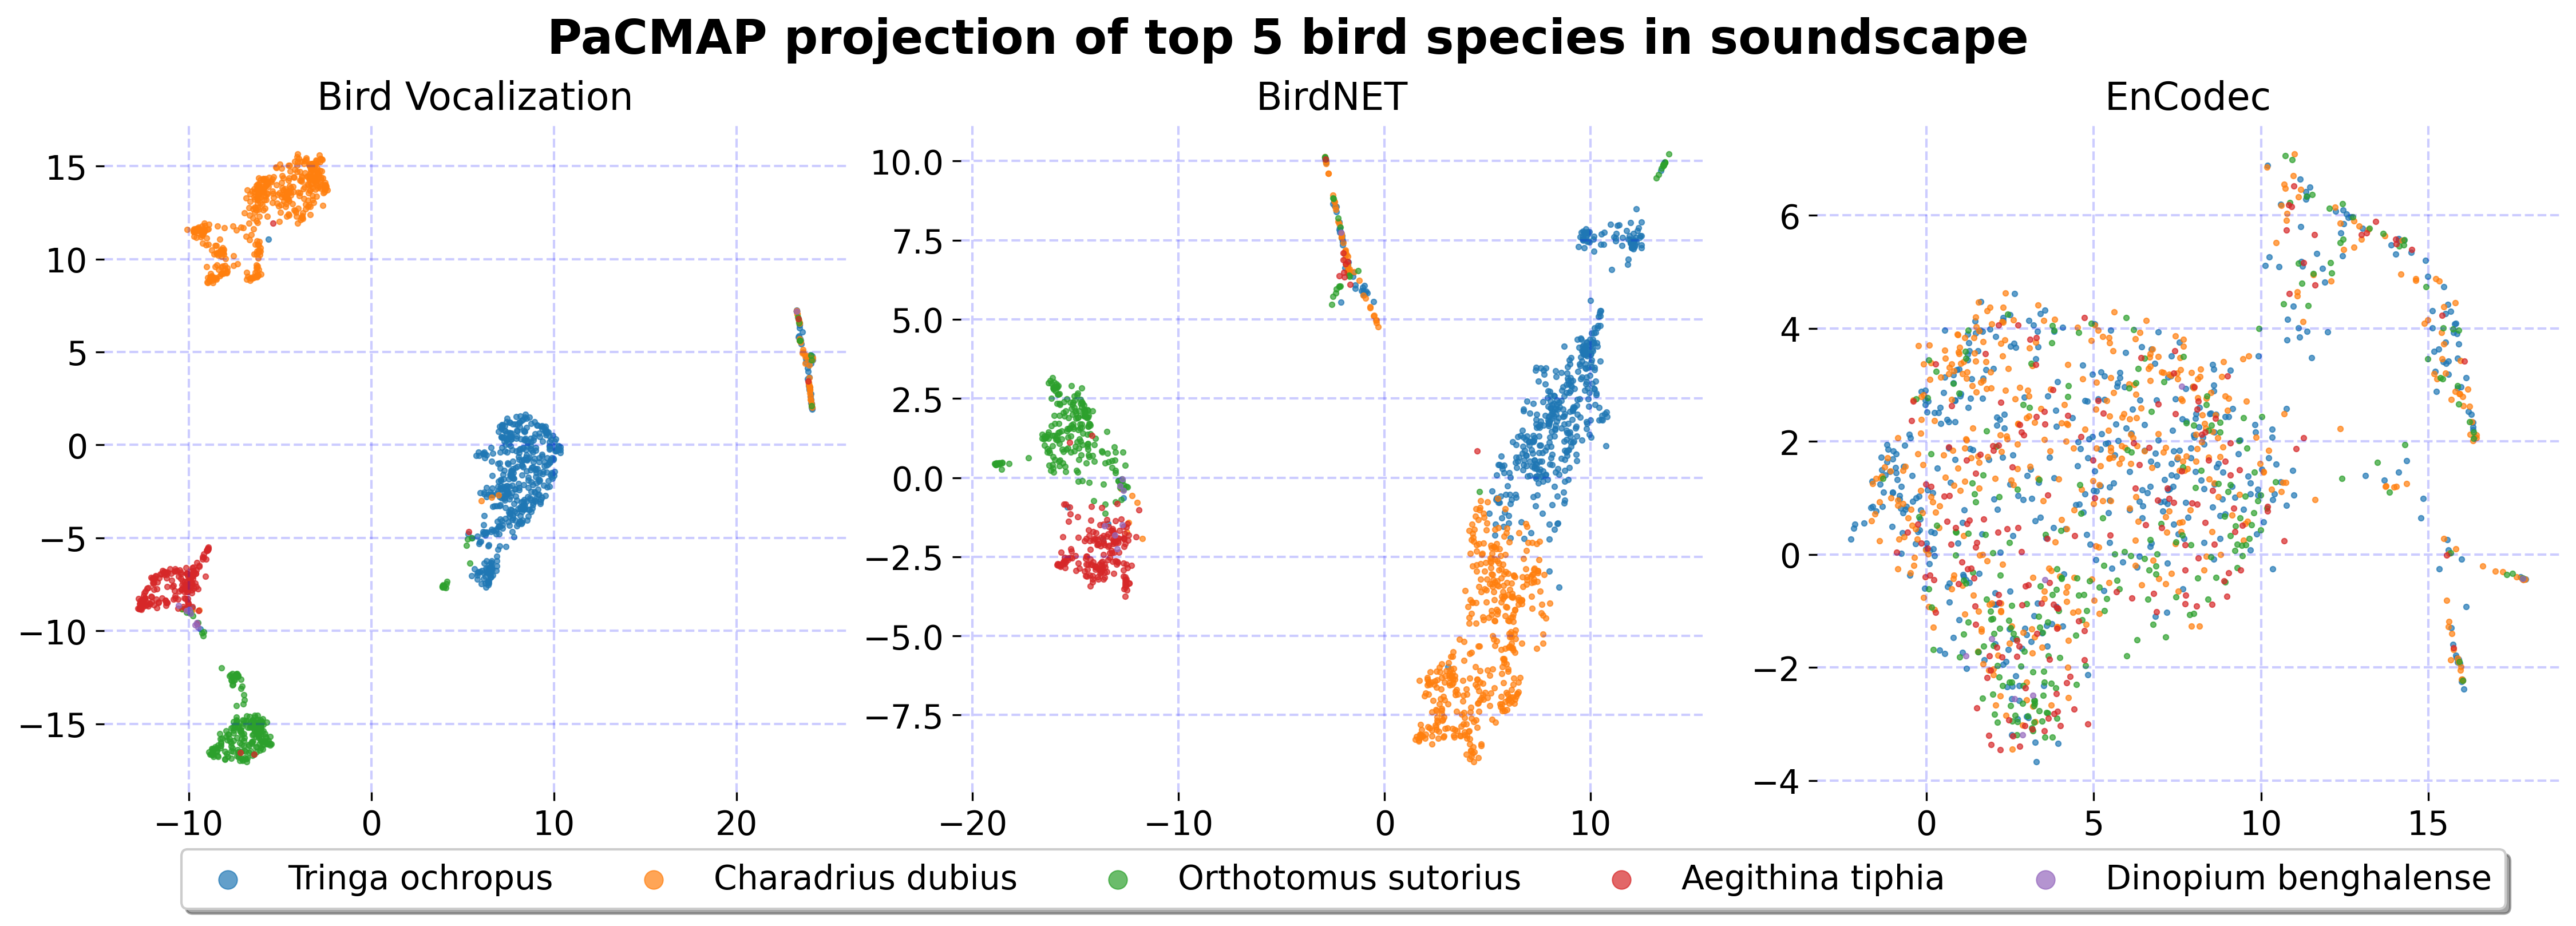

In [32]:
plot_pacmap_clusters(
    [google_pandas_df, birdnet_pandas_df, encodec_pandas_df],
    [google_transformed, birdnet_transformed, encodec_transformed],
)